## Monitoring Results
---

In [1]:
import sys, os, json
sys.path.insert(1, "../../")
from src.combine import combine_data
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import OrderedDict
import src.monitoring.refit as refit
import src.monitoring.governance as gvrn
import src.monitoring.monitoring as mntr
import src.monitoring.utils as mu

%matplotlib inline
plt.style.use('seaborn')

%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

In [2]:
# load final data computed locally
# df = pd.read_feather("../../data/combined_all_features/combined_1613851268.feather") 
# we've previous sent combined_1613851268.feather to s3, let's download it
dev_path = "s3://sofi-data-science/jxu/monitoring/customer-risk-v1/2021-02/dev-data.parquet"
df = pd.read_parquet(dev_path)
df = mu.prep_customer_data(df)

In [3]:
# artifacts path
artifact_path = "../../artifacts/monitoring-2021Q1/monitoring" 
os.makedirs(artifact_path, exist_ok=True)

# load configs
with open("../../config.json", "r") as f:
    config = json.load(f)
    
# find the first day to start monitoring
mntr_start_dt = pd.to_datetime("2020-09-01")
test_dfs = OrderedDict()

In [4]:
# load model from s3
prev_model_s3_key = "jxu/money-risk-models/customer-risk-model/models/customer_risk_target_no_giact_time_since_last_link.pkl"
model = mu.read_pickle_from_s3("sofi-data-science", prev_model_s3_key)

In [5]:
config["static_sample_dates"]

['2019-03-15',
 '2019-05-27',
 '2019-08-08',
 '2019-10-20',
 '2020-01-01',
 '2020-03-14',
 '2020-05-26',
 '2020-07-01',
 '2020-08-01',
 '2020-09-01',
 '2020-10-01',
 '2020-11-01',
 '2020-12-01',
 '2021-01-01',
 '2021-02-01',
 '2021-02-19']

### Active Accounts
---

  0%|          | 0/16 [00:00<?, ?it/s]

2020-09-01 (365546, 98)
data imbalance:  101.09126106194691


 62%|██████▎   | 10/16 [00:09<00:05,  1.08it/s]

2020-10-01 (432998, 98)
data imbalance:  104.11108439528732


 69%|██████▉   | 11/16 [00:19<00:10,  2.12s/it]

2020-11-01 (503062, 98)
data imbalance:  108.84076157507573


 75%|███████▌  | 12/16 [00:31<00:14,  3.51s/it]

2020-12-01 (567591, 98)
data imbalance:  104.27907404005144


 81%|████████▏ | 13/16 [00:43<00:15,  5.09s/it]

2021-01-01 (650547, 98)
data imbalance:  179.8581697539397


 88%|████████▊ | 14/16 [00:57<00:13,  6.99s/it]

2021-02-01 (723696, 98)
data imbalance:  296.47521507578864


 94%|█████████▍| 15/16 [01:13<00:08,  8.99s/it]

2021-02-19 (740625, 98)
data imbalance:  406.71334431630976


100%|██████████| 16/16 [01:29<00:00,  5.59s/it]


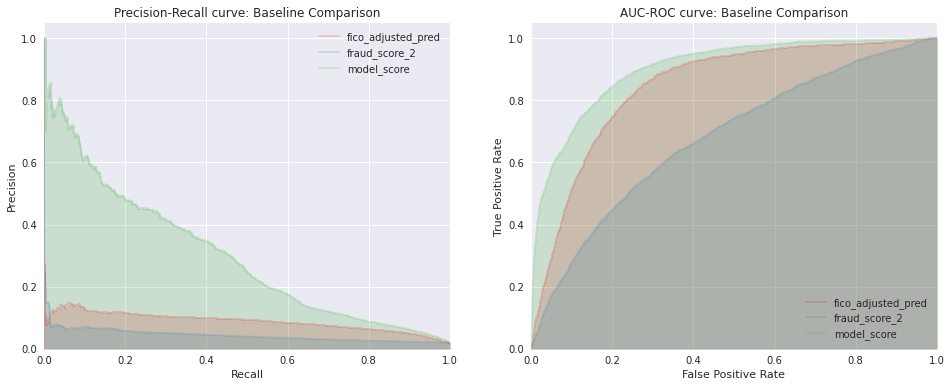

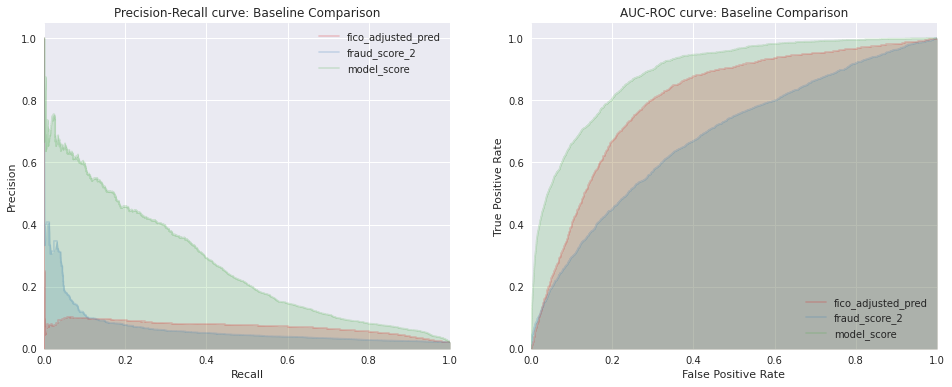

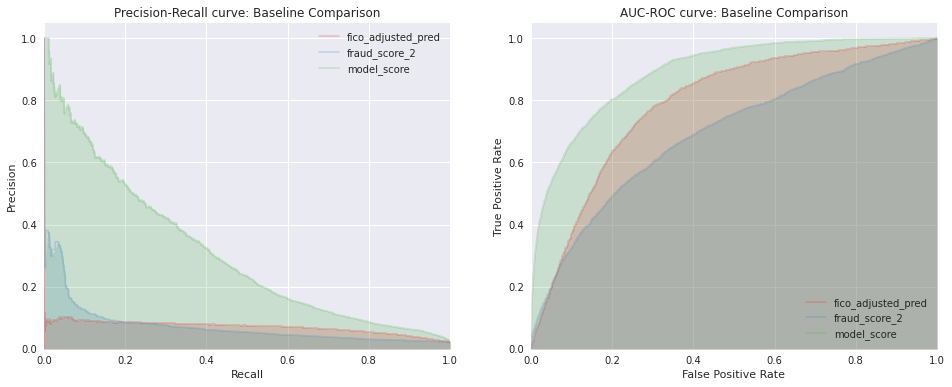

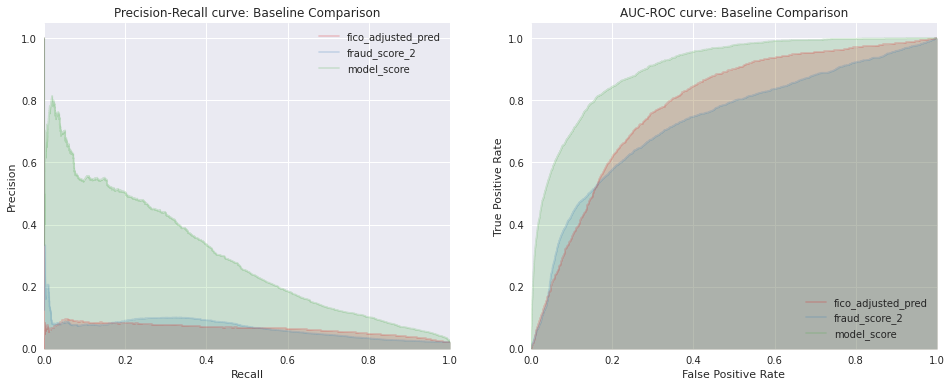

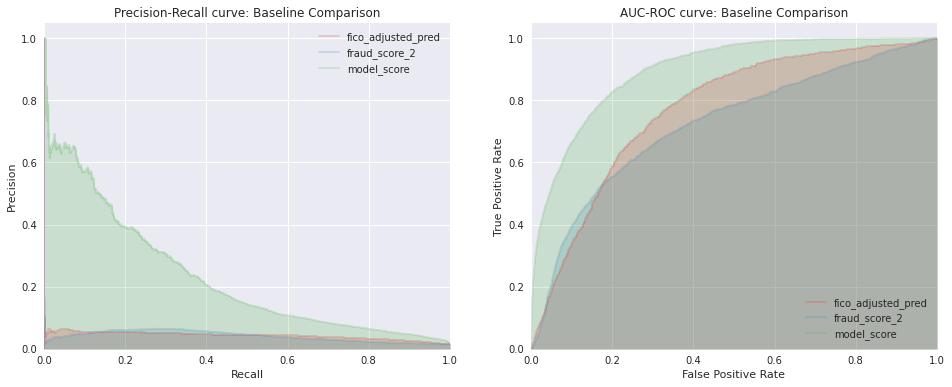

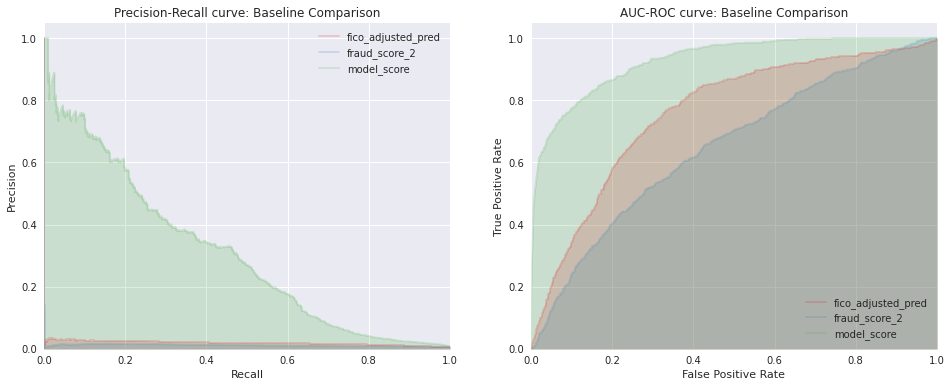

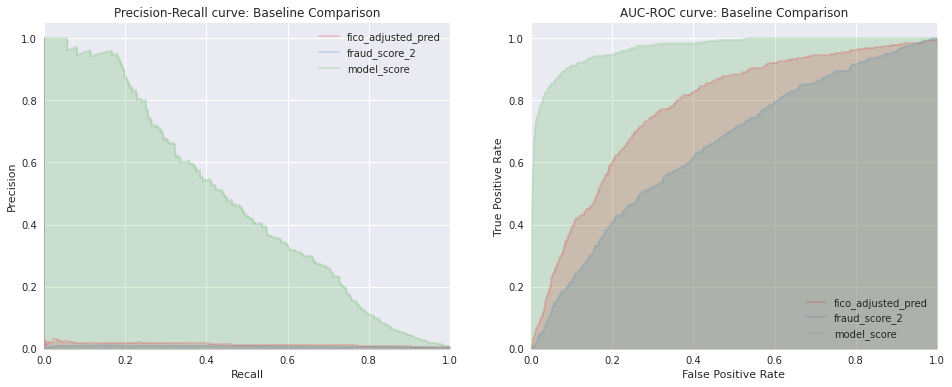

In [10]:
# get all the snapshots
for dt_str in tqdm(config["static_sample_dates"]):
    dt = pd.to_datetime(dt_str)
    if dt >= mntr_start_dt:
        # set folder:
        mntr_path = os.path.join(artifact_path, dt_str)
        os.makedirs(mntr_path, exist_ok=True)

        # get data on that date
        df_ = df[df.is_static 
                 & (df.sample_date == dt)]
        print(dt_str, df_.shape)
        
        # see data imbalance
        print("data imbalance: ", 1/df_.target.value_counts(normalize=True).iloc[1])
        
        # should have been processed when loaded, if not uncomment
        df_ = mu.prep_customer_data(df_)

        # make model pred and score
        df_["model_pred"] = model.predict_proba(df_[model.feature_name_])[:,1]
        df_["model_score"] = mu.scale_scores(df_["model_pred"])
        
        # insert into records
        test_dfs[dt_str] = df_
        pred_cols = ["fico_adjusted_pred", "fraud_score_2", "model_score"]
        report = mntr.get_pred_reports(df_[df_.is_active], "target", pred_cols, dropna=True)
        
        # store report in monitoring
        report.to_csv(os.path.join(mntr_path, f"{dt_str}_perf.csv"))
        
        # model prediction
        mntr.get_segmented_performances(
            {dt_str: df_[df_.is_active]},
            "target",
            ["model_score"],
            mntr_path,
            model_name="customer_risk",
        )

        # on vs fico adjusted - only valid fico
        mntr.get_model_vs_baseline(
            df_[df_.fico_score.between(300,850)],
            "target",
            "model_score",
            "fico_adjusted",
            mntr_path,
        )
        
        # auc/pr plots - on valid fico and sigma score
        plot_df = df_[df_.is_active].copy()
        plot_df = plot_df[
            ~plot_df[pred_cols].isna().any(axis=1) 
            & plot_df["fico_score"].between(300, 850)
        ]
        mntr.save_valid_performance_plots(
            {dt_str: plot_df}, "target", pred_cols, mntr_path, dropna=False
        )

The model performance degraded after refitting because we were looking at a segment behavior. Let's get the full performance of the original model to get a comparison

### Full Population
---

  0%|          | 0/16 [00:00<?, ?it/s]

2020-09-01 (365546, 98)
data imbalance:  101.09126106194691


 62%|██████▎   | 10/16 [00:20<00:12,  2.04s/it]

2020-10-01 (432998, 98)
data imbalance:  104.11108439528732


 69%|██████▉   | 11/16 [00:44<00:23,  4.79s/it]

2020-11-01 (503062, 98)
data imbalance:  108.84076157507573


 75%|███████▌  | 12/16 [01:12<00:33,  8.36s/it]

2020-12-01 (567591, 98)
data imbalance:  104.27907404005144


 81%|████████▏ | 13/16 [01:44<00:37, 12.56s/it]

2021-01-01 (650547, 98)
data imbalance:  179.8581697539397


 88%|████████▊ | 14/16 [02:22<00:35, 17.57s/it]

2021-02-01 (723696, 98)
data imbalance:  296.47521507578864


 94%|█████████▍| 15/16 [03:03<00:22, 22.97s/it]

2021-02-19 (740625, 98)
data imbalance:  406.71334431630976


100%|██████████| 16/16 [03:46<00:00, 14.15s/it]


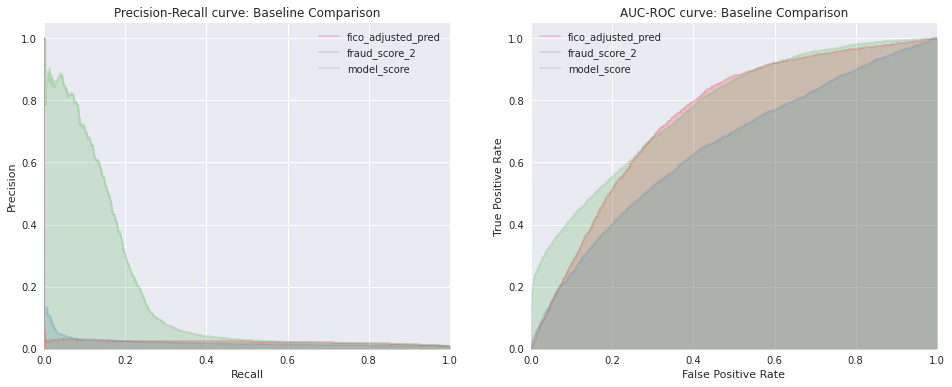

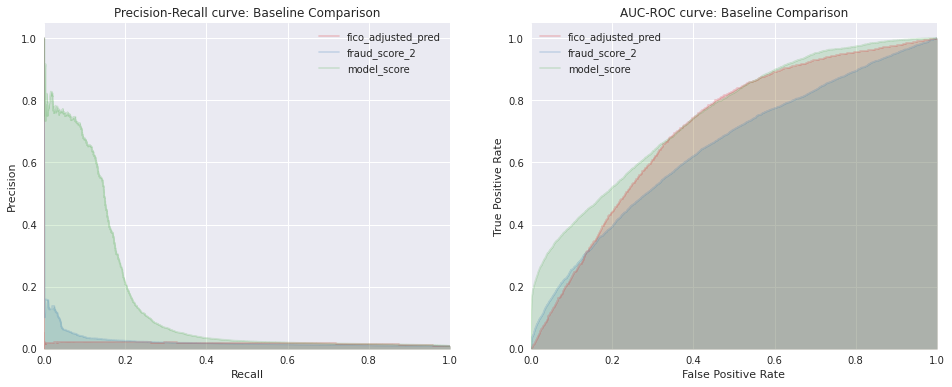

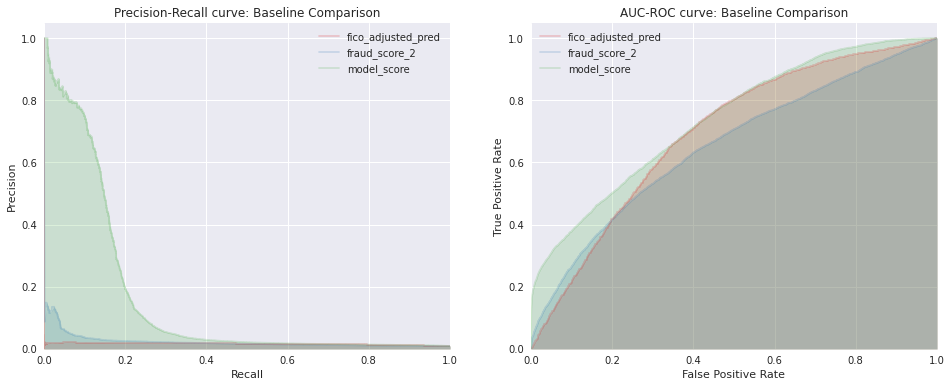

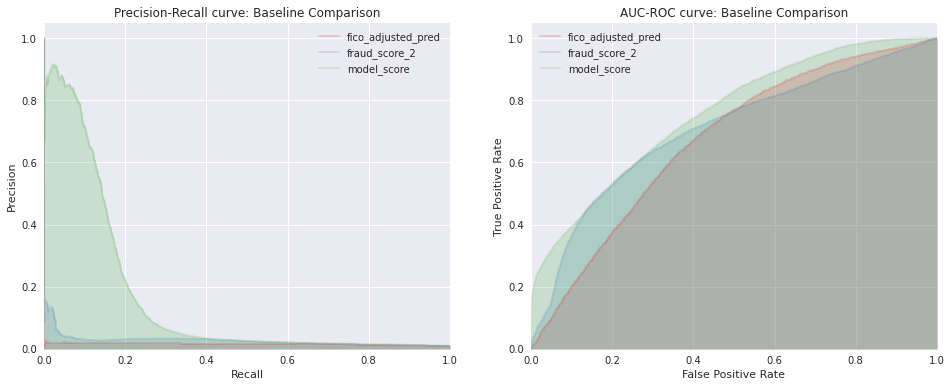

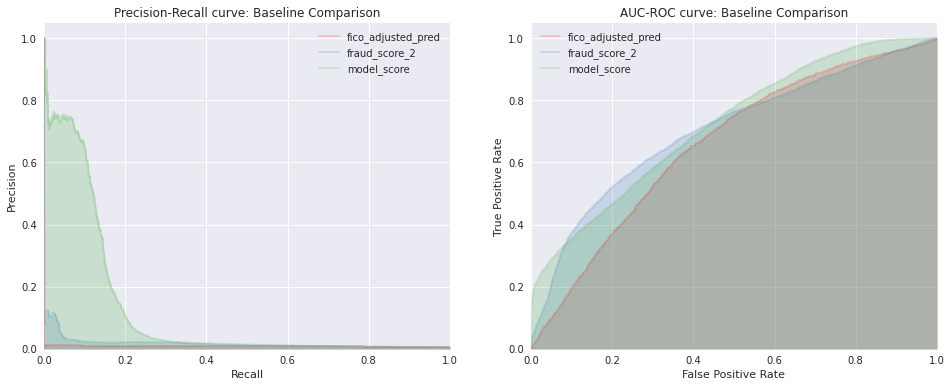

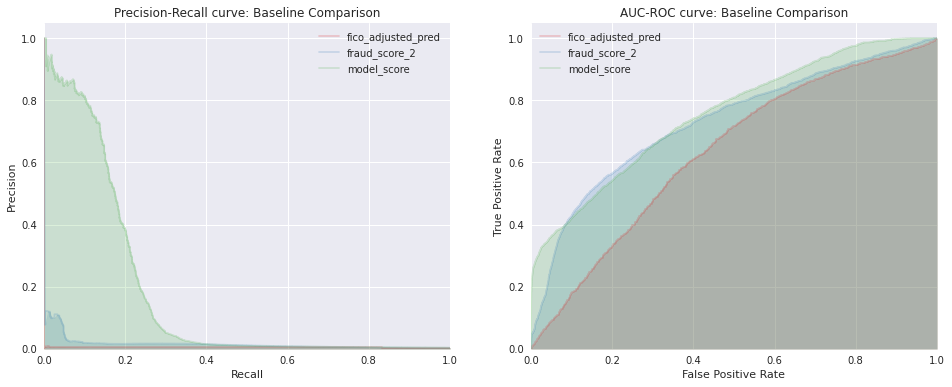

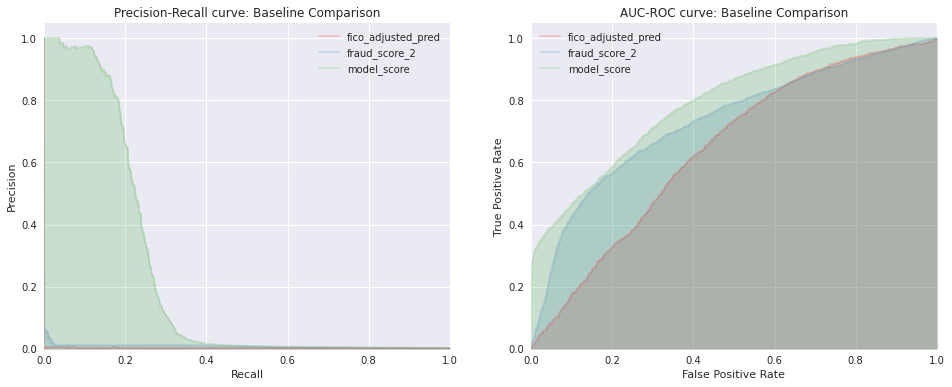

In [11]:
# get all the snapshots
for dt_str in tqdm(config["static_sample_dates"]):
    dt = pd.to_datetime(dt_str)
    if dt >= mntr_start_dt:
        # set folder:
        mntr_path = os.path.join(artifact_path, dt_str+"_all")
        os.makedirs(mntr_path, exist_ok=True)

        # get data on that date
        df_ = df[df.is_static 
                 & (df.sample_date == dt)]
        print(dt_str, df_.shape)
        
        # see data imbalance
        print("data imbalance: ", 1/df_.target.value_counts(normalize=True).iloc[1])
        
        # should have been processed when loaded, if not uncomment
        df_ = mu.prep_customer_data(df_)

        # make model pred and score
        df_["model_pred"] = model.predict_proba(df_[model.feature_name_])[:,1]
        df_["model_score"] = mu.scale_scores(df_["model_pred"])
        
        # insert into records
        test_dfs[dt_str] = df_
        pred_cols = ["fico_adjusted_pred", "fraud_score_2", "model_score"]
        report = mntr.get_pred_reports(df_, "target", pred_cols, dropna=True)
        
        # store report in monitoring
        report.to_csv(os.path.join(mntr_path, f"{dt_str}_perf.csv"))
        
        # model prediction
        mntr.get_segmented_performances(
            {dt_str: df_},
            "target",
            ["model_score"],
            mntr_path,
            model_name="customer_risk",
        )

        # on vs fico adjusted - only valid fico
        mntr.get_model_vs_baseline(
            df_[df_.fico_score.between(300,850)],
            "target",
            "model_score",
            "fico_adjusted",
            mntr_path,
        )
        
        # auc/pr plots - on valid fico and sigma
        plot_df = df_.copy()
        plot_df = plot_df[
            ~plot_df[pred_cols].isna().any(axis=1) 
            & plot_df["fico_score"].between(300, 850)
        ]
        mntr.save_valid_performance_plots(
            {dt_str: plot_df}, "target", pred_cols, mntr_path, dropna=False
        )